Adapted from Chris Tralie's CS 477 at Ursinus College

In [15]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import string
import time
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
import glob

In [79]:
imgres = 64

# Setup model
class AutoencoderCNN(Model):
    def __init__(self, imgres, d, k):
        """
        Parameters
        ----------
        imgres: int
            Resolution of each grayscale image
        d: int
            Dimension of the embedding
        k: int
            Kernel size at each layer
        """
        super(AutoencoderCNN, self).__init__()
        self.imgres = imgres
        self.d = d
        self.k = k
        print(imgres,d,k)
        self.encoder = Sequential([
            layers.Input(shape=(imgres, imgres, 1)),
            layers.Conv2D(32, (k, k), activation='leaky_relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2D(64, (k, k), activation='leaky_relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2D(128, (k, k), activation='leaky_relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Flatten(),
            layers.Dense(d, activation='leaky_relu')
        ])
        
        self.decoder = Sequential([
            layers.Input(shape=(d,)),
            layers.Dense(2*imgres**2),
            layers.Reshape((imgres//8, imgres//8, 128)),
            layers.Conv2DTranspose(128, kernel_size=k, strides=2, activation='leaky_relu', padding='same'),
            layers.Dropout(0.2),
            layers.Conv2DTranspose(64, kernel_size=k, strides=2, activation='leaky_relu', padding='same'),
            layers.Dropout(0.2),
            layers.Conv2DTranspose(32, kernel_size=k, strides=2, activation='leaky_relu', padding='same'),
            layers.Dropout(0.2),
            layers.Conv2DTranspose(1, kernel_size=(k, k), activation='sigmoid', padding='same')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder = AutoencoderCNN(imgres=imgres, d=128, k=3)
print(autoencoder.encoder.summary())
print(autoencoder.decoder.summary())

64 128 3
Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_187 (Conv2D)         (None, 32, 32, 32)        320       
                                                                 
 dropout_202 (Dropout)       (None, 32, 32, 32)        0         
                                                                 
 conv2d_188 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 dropout_203 (Dropout)       (None, 16, 16, 64)        0         
                                                                 
 conv2d_189 (Conv2D)         (None, 8, 8, 128)         73856     
                                                                 
 dropout_204 (Dropout)       (None, 8, 8, 128)         0         
                                                                 
 flatten_36 (Flatten)        (None, 8192)   

In [80]:
class PlotterCallback(tf.keras.callbacks.Callback):
    def __init__(self, n=10):
        self.epoch = 0
        self.n = n
        self.plot_imgs = datagen.flow_from_directory('../bonus/autoencoder/Valid'.format(imgres, imgres),
        class_mode="input", batch_size=n, shuffle=True,
        target_size=(imgres, imgres), color_mode="grayscale")
        self.X = self.plot_imgs.next()[0]
    
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))
        X = self.X
        encoded_imgs = autoencoder.encoder(X).numpy()
        print(encoded_imgs.shape)
        decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
        plt.figure(figsize=(20, 5))
        n = self.n
        for i in range(n):
            # display original
            plt.subplot(3, n, i + 1)
            plt.imshow(X[i, :, :, 0], cmap='gray')
            plt.title("original")
            plt.axis("off")

            # display reconstruction
            plt.subplot(3, n, n+i+1)
            plt.imshow(decoded_imgs[i], cmap='gray')
            plt.title("reconstructed")
            plt.axis("off")

            # display difference
            plt.subplot(3, n, 2*n+i+1)
            plt.imshow(X[i, :, :, :] - decoded_imgs[i], cmap='gray')
            plt.title("Difference")
            plt.axis("off")
        self.epoch += 1
        plt.savefig("Epoch{}.png".format(self.epoch), bbox_inches='tight')
        plt.show()

Found 9381 images belonging to 1 classes.
Found 94 images belonging to 1 classes.


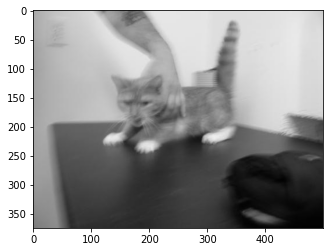

In [81]:

img = load_img('../bonus/autoencoder/Train/0.jpg') 
plt.imshow(img, cmap='gray')

datagen = ImageDataGenerator(rescale=1/255)
train_it = datagen.flow_from_directory('../bonus/autoencoder/Train'.format(imgres, imgres),
        class_mode="input", batch_size=64, shuffle=True,
        target_size=(imgres, imgres), color_mode="grayscale")
test_it = datagen.flow_from_directory('../bonus/autoencoder/Valid'.format(imgres, imgres),
        class_mode="input", batch_size=64, shuffle=True,
        target_size=(imgres, imgres), color_mode="grayscale")

Found 94 images belonging to 1 classes.
Epoch 1/25
147/147 [==============================] - ETA: 0s - loss: 0.0454End epoch 0 of training; got log keys: ['loss', 'val_loss']
(10, 128)


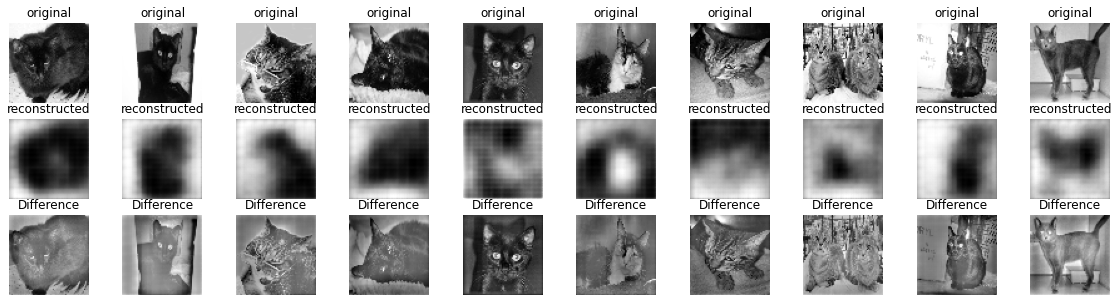

147/147 [==============================] - 116s 777ms/step - loss: 0.0454 - val_loss: 0.0221
Epoch 2/25
147/147 [==============================] - ETA: 0s - loss: 0.0212End epoch 1 of training; got log keys: ['loss', 'val_loss']
(10, 128)


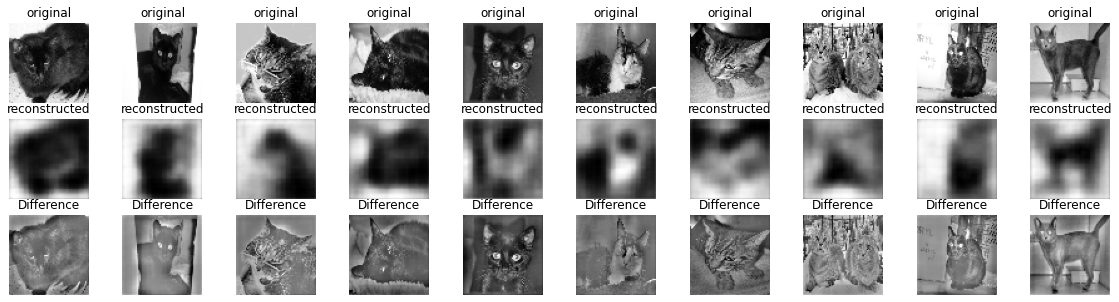

147/147 [==============================] - 125s 853ms/step - loss: 0.0212 - val_loss: 0.0163
Epoch 3/25
147/147 [==============================] - ETA: 0s - loss: 0.0174End epoch 2 of training; got log keys: ['loss', 'val_loss']
(10, 128)


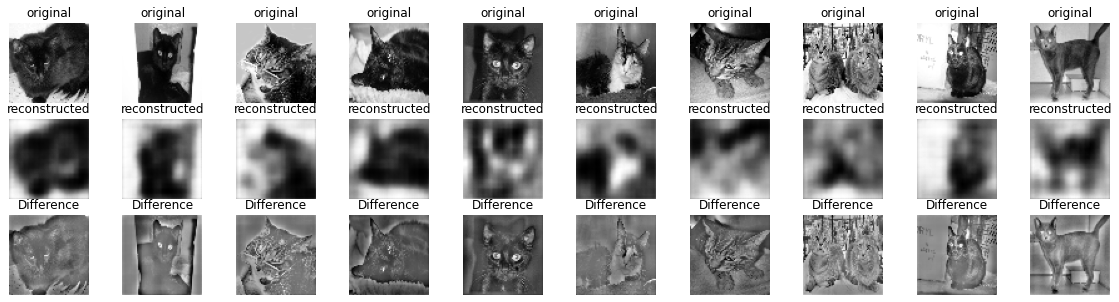

147/147 [==============================] - 116s 784ms/step - loss: 0.0174 - val_loss: 0.0142
Epoch 4/25
147/147 [==============================] - ETA: 0s - loss: 0.0157End epoch 3 of training; got log keys: ['loss', 'val_loss']
(10, 128)


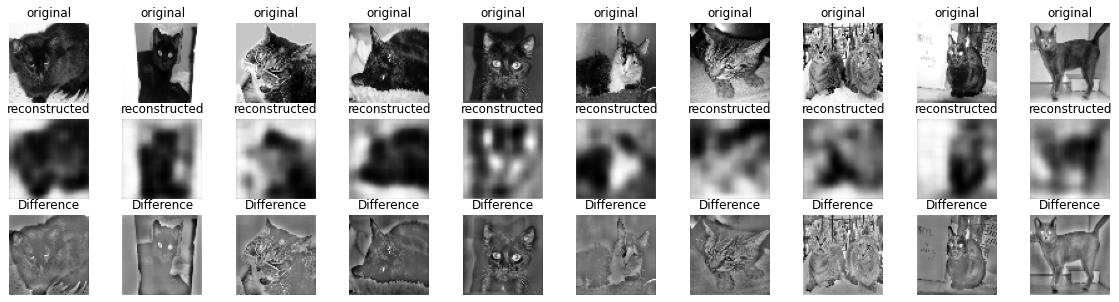

147/147 [==============================] - 121s 819ms/step - loss: 0.0157 - val_loss: 0.0129
Epoch 5/25
147/147 [==============================] - ETA: 0s - loss: 0.0145End epoch 4 of training; got log keys: ['loss', 'val_loss']
(10, 128)


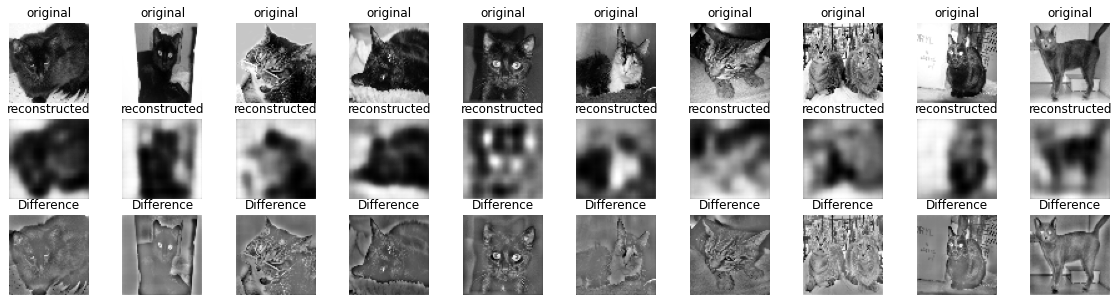

147/147 [==============================] - 130s 882ms/step - loss: 0.0145 - val_loss: 0.0121
Epoch 6/25
147/147 [==============================] - ETA: 0s - loss: 0.0137End epoch 5 of training; got log keys: ['loss', 'val_loss']
(10, 128)


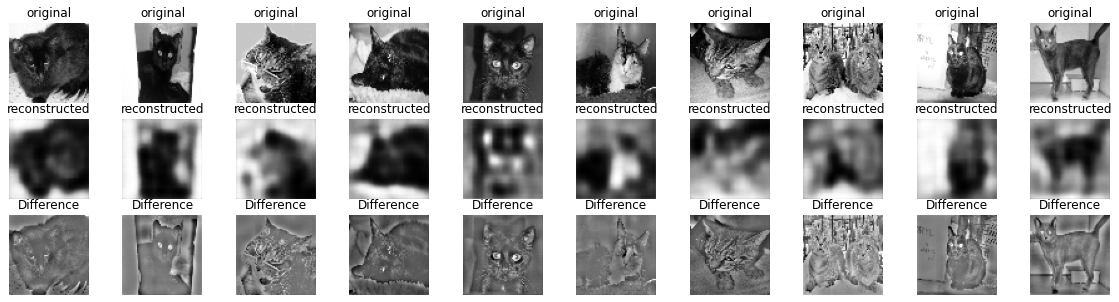

147/147 [==============================] - 121s 817ms/step - loss: 0.0137 - val_loss: 0.0115
Epoch 7/25
147/147 [==============================] - ETA: 0s - loss: 0.0131End epoch 6 of training; got log keys: ['loss', 'val_loss']
(10, 128)


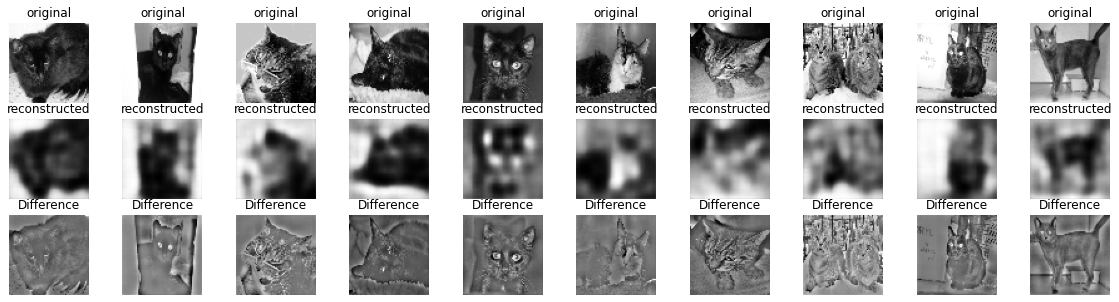

147/147 [==============================] - 123s 836ms/step - loss: 0.0131 - val_loss: 0.0109
Epoch 8/25
147/147 [==============================] - ETA: 0s - loss: 0.0126End epoch 7 of training; got log keys: ['loss', 'val_loss']
(10, 128)


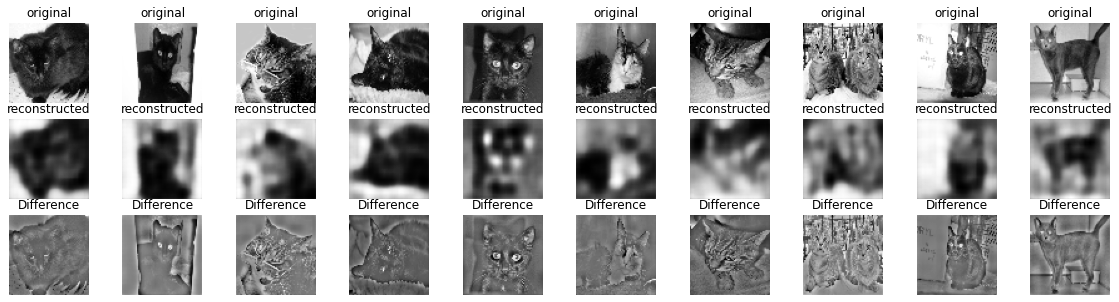

147/147 [==============================] - 126s 857ms/step - loss: 0.0126 - val_loss: 0.0105
Epoch 9/25
147/147 [==============================] - ETA: 0s - loss: 0.0122End epoch 8 of training; got log keys: ['loss', 'val_loss']
(10, 128)


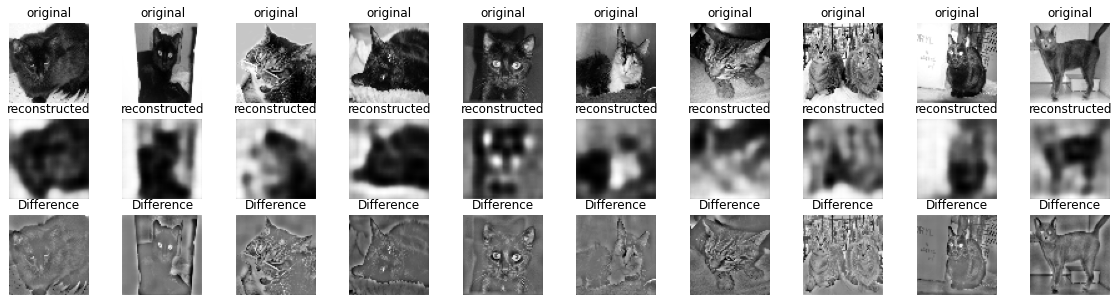

147/147 [==============================] - 128s 866ms/step - loss: 0.0122 - val_loss: 0.0102
Epoch 10/25
147/147 [==============================] - ETA: 0s - loss: 0.0119End epoch 9 of training; got log keys: ['loss', 'val_loss']
(10, 128)


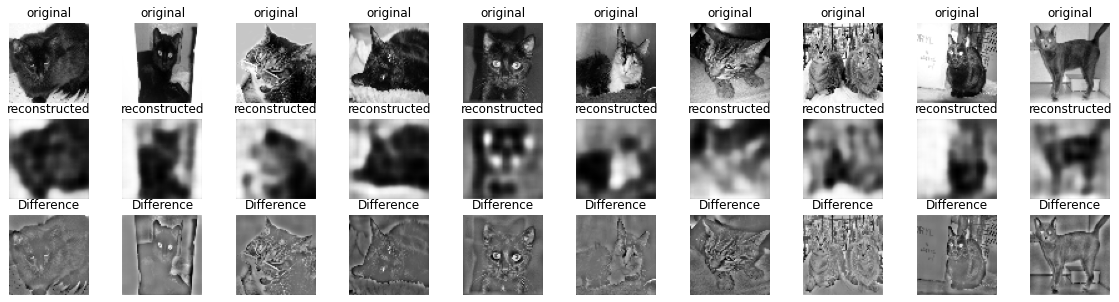

147/147 [==============================] - 127s 862ms/step - loss: 0.0119 - val_loss: 0.0099
Epoch 11/25
147/147 [==============================] - ETA: 0s - loss: 0.0116End epoch 10 of training; got log keys: ['loss', 'val_loss']
(10, 128)


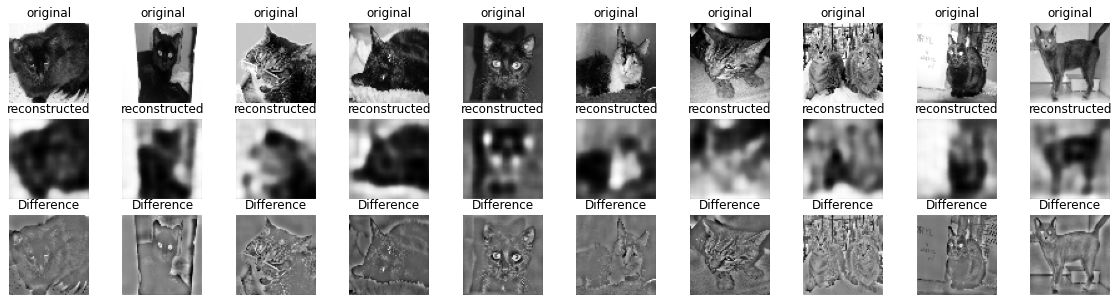

147/147 [==============================] - 141s 959ms/step - loss: 0.0116 - val_loss: 0.0097
Epoch 12/25
  7/147 [>.............................] - ETA: 1:55 - loss: 0.0117

KeyboardInterrupt: 

In [82]:
autoencoder.compile(optimizer=Adam(3e-4), loss=losses.MeanSquaredError())
history = autoencoder.fit(train_it, 
                           steps_per_epoch=len(train_it),
                           validation_data=test_it,
                           validation_steps=len(test_it),
                           epochs=25,
                           verbose=1,
                           callbacks=[PlotterCallback()])

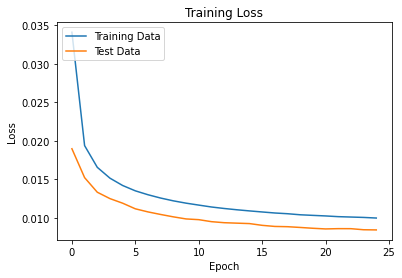

In [83]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Data', 'Test Data'], loc='upper left')

[[ 0.36365099 -0.57124146 -2.24982094 -0.04572127 -0.7623621   0.27381251
  -0.46977491 -0.28089856 -1.84885116  0.89819736 -0.05504846 -0.08784695
  -2.45880068  0.19547292  1.11674366 -0.73704871 -0.37318174  1.28677856
  -0.5078776   1.86896335  0.38249207 -1.20543122 -0.55466725 -2.23541235
  -0.13419347 -1.52287624 -0.69169099 -1.49436769 -1.29809662 -0.64439226
   0.70374901 -0.70314049 -0.45782775 -0.36123666 -0.23116846 -0.18226894
   0.21925094 -0.65435838 -0.09766458  1.46278022  0.52346102 -0.98701142
   0.59982174 -1.29426715  0.41508662  0.06726141 -0.38352217  0.76913507
   0.16934828 -1.29085469 -0.96013425  0.4173405  -2.00407608 -0.1325844
  -0.1890487   0.26696987 -0.9545931  -0.94540622  0.56162225 -0.04396481
  -0.14732489 -0.42755104 -0.03470711 -1.70312179  0.10209181  0.30309277
  -0.55009911  0.38287504 -0.99443193  0.63477    -0.43802978 -1.83313165
   1.16701813  0.44465108  0.12858884  0.23753583 -0.46203722 -1.32656806
  -1.09334076 -0.94791051  1.42706351 -

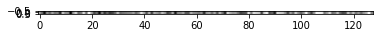

In [90]:
noise = np.random.randn(1, 128)
print(noise)
plt.imshow(noise, cmap='gray')

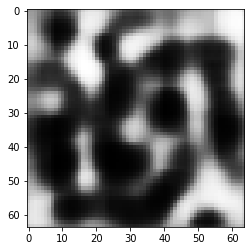

In [91]:

x = autoencoder.decoder(noise).numpy()

plt.imshow(x[0, :, :, 0], cmap='gray')

In [ ]:
autoencoder.save_weights("models/catautoencoder")